In [27]:
import rdkit
rdkit.__version__

'2023.03.1'

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pandas as pd

from tensorflow import keras

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole

from sklearn import datasets, metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler


from scipy import interp
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras import backend as K 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers

# Test dataset

In [29]:
test_df = pd.read_csv('test_DILIrank_raw.csv')
test_df = test_df.dropna().drop_duplicates().reset_index(drop=True)
test_df

,name,smiles,toxicity
0,raltegravir,CC1=NN=C(O1)C(=O)NC(C)(C)C2=N/C(=C(/NCC3=CC=C(...,1
1,riluzole,C1=CC2=C(C=C1OC(F)(F)F)SC(=N2)N,1
2,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,1
3,fenoprofen,CC(C1=CC(=CC=C1)OC2=CC=CC=C2)C(=O)O,1
4,acetazolamide,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1
...,...,...,...
447,Levoleucovorin,C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...,0
448,levomefolate calcium,CN1[C@H](CNC2=C1C(=O)N=C(N2)N)CNC3=CC=C(C=C3)C...,0
449,daunorubicin,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,0
450,nystatin,C[C@@H]1[C@H]([C@@H]([C@@H](C(O1)OC\2CC(C(C(CC...,0


In [30]:
test_df['toxicity'].value_counts()

toxicity
0    268
1    184
Name: count, dtype: int64

## For vit

In [5]:
# transform smiles to mol
mols = [Chem.MolFromSmiles(smiles) for smiles in test_df["smiles"]]

# if smiles don't transform to mol, add to non_list
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('none_list에 추가됨')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# modify index
if len(none_list) != 0 :
    test_df = test_df.drop(none_list, axis=0)
    test_df = test_df.reset_index(drop = True)

In [6]:
# create fingerprint
bit_info_list = [] # bit vector
bit_info = {} #bit vector
fps = []

b = 0

# mol to fingerprint Bit Vector
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy()) 
    
# to array

arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
test_x = np.stack([i.tolist() for i in arr_list])
test_x = test_x.astype(np.float32)
test_finprt = pd.DataFrame(test_x)

In [7]:
# create physicochemical properties

from rdkit.Chem import QED

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
qe

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,444.423,0.98202,8,3,150.02,6,2,3
1,234.202,2.77710,3,1,48.14,1,2,0
2,1202.635,3.26900,12,5,278.80,15,0,1
3,242.274,3.66700,3,1,46.53,4,2,0
4,222.251,-0.85610,5,2,115.04,2,1,1
...,...,...,...,...,...,...,...,...
447,473.446,-0.73110,11,7,219.84,10,2,1
448,497.525,-3.30790,11,5,208.43,9,2,1
449,527.526,1.02890,11,5,185.84,4,3,1
450,926.107,0.77830,18,12,327.45,3,0,1


In [8]:
from pickle import load 

#QED datapreprocessing 
load_ss = load(open('./standard_scaler_test.pkl','rb'))

ss = StandardScaler()

ss.fit(qe)
qe_scaled = ss.transform(qe) 


qe_scaled = pd.DataFrame(qe_scaled)
qe_scaled.columns =['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS']
qe_scaled

/data/home/bmi-lab/anaconda3/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,-0.031682,-0.078496,0.124693,-0.070660,0.065800,-0.124521,0.286838,1.806079
1,-0.372504,0.309422,-0.362862,-0.288668,-0.316390,-0.396949,0.286838,-0.882223
2,1.197573,0.415722,0.514738,0.147348,0.548903,0.365849,-1.212015,0.013878
3,-0.359417,0.501730,-0.362862,-0.288668,-0.322430,-0.233492,0.286838,-0.882223
4,-0.391879,-0.475714,-0.167840,-0.179664,-0.065423,-0.342464,-0.462589,0.013878
...,...,...,...,...,...,...,...,...
447,0.015372,-0.448702,0.417227,0.365357,0.327722,0.093421,0.286838,0.013878
448,0.054410,-1.005549,0.417227,0.147348,0.284919,0.038936,0.286838,0.013878
449,0.103049,-0.068365,0.417227,0.147348,0.200175,-0.233492,1.036265,0.013878
450,0.749251,-0.122520,1.099804,0.910377,0.731408,-0.287978,-1.212015,0.013878


In [9]:
input_df = pd.concat([test_finprt,qe_scaled,test_df['toxicity']],axis=1)
input_df

,0,1,2,3,4,5,6,7,8,9,...,1023,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,toxicity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.031682,-0.078496,0.124693,-0.070660,0.065800,-0.124521,0.286838,1.806079,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.372504,0.309422,-0.362862,-0.288668,-0.316390,-0.396949,0.286838,-0.882223,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.197573,0.415722,0.514738,0.147348,0.548903,0.365849,-1.212015,0.013878,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.359417,0.501730,-0.362862,-0.288668,-0.322430,-0.233492,0.286838,-0.882223,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.391879,-0.475714,-0.167840,-0.179664,-0.065423,-0.342464,-0.462589,0.013878,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015372,-0.448702,0.417227,0.365357,0.327722,0.093421,0.286838,0.013878,0
448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.054410,-1.005549,0.417227,0.147348,0.284919,0.038936,0.286838,0.013878,0
449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.103049,-0.068365,0.417227,0.147348,0.200175,-0.233492,1.036265,0.013878,0
450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.749251,-0.122520,1.099804,0.910377,0.731408,-0.287978,-1.212015,0.013878,0


In [10]:
input_df['toxicity'].value_counts()

toxicity
0    268
1    184
Name: count, dtype: int64

In [11]:
x_test = input_df.iloc[:,:1032]
y_test = input_df['toxicity']

# model import

In [15]:
from keras.models import load_model

model = load_model('DILIattention.h5', custom_objects={'precision':precision, 'recall':precision,'f1score':f1score})

2023-08-03 08:17:12.307758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-08-03 08:17:12.318978: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [31]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1032)]       0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 1032)         1066056     ['input_11[0][0]']               
                                                                                                  
 softmax_10 (Softmax)           (None, 1032)         0           ['dense_30[0][0]']               
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 1032)        0           ['input_11[0][0]',               
 a)                                                               'softmax_10[0][0]']      

In [16]:
def MakeAttentionScore(dataframe, data, model, fp_size, thresholds=0.5, label="true_pos"):
    global attention_score
    
    attn_ = tf.keras.Model(inputs = model.inputs, outputs = model.layers[2].output) # attention layer
    
    attention_score = attn_.predict(data)
    attention_score[:, :fp_size] = attention_score[:, :fp_size] * data.iloc[:, :fp_size]
    attention_score = pd.DataFrame(attention_score)
    
    
    if label == "true_pos":
        pred = model.predict(data)
        pred[pred >= thresholds] = 1
        pred[pred < thresholds] = 0
        pred = pd.DataFrame(pred)
        pred_idx = pred[pred[0]==1].index
        dataframe = dataframe.loc[pred_idx]
        true_positive_idx = dataframe[dataframe['toxicity']==1].index    
        attention_score = attention_score.loc[true_positive_idx]
        attention_score = attention_score.transpose()
        
    elif label == "pred_pos":
        pred = model.predict(data)
        pred[pred >= thresholds] = 1
        pred[pred < thresholds] = 0
        pred = pd.DataFrame(pred)
        pred_idx = pred[pred[0]==1].index
        
        attention_score = attention_score.loc[pred_idx]
        attention_score = attention_score.transpose()
        
    elif label == "all":
        attention_score = attention_score.transpose()
        
    return attention_score

In [17]:
def MakeAttentionIndex(attention_score, dataframe):
    attention_index = attention_score.transpose().index
    inform = dataframe.loc[attention_index]
    return inform

def FindDrug(inform, drug_name):
    if type(drug_name) == str:
        selected_drug = inform[inform['name']==drug_name]
        print('INDEX')
        print(selected_drug)
    else:
        raise ValueError('The \'drug_name\' value must be string type')

In [18]:
def AttentionAnalysis(mols=None, attention_score=None, dataframe=None, bit_info_list=None, index=None, drug_name=None, rank=10, fp_size=None):
    highlightAtomLists = [] # molecular substructure atom for highlights
    rank_information = []
    legends = [] # molecular substructure
    
    # Check the Input Values
    if mols is None:
        raise ValueError('Please input the \'mols\' value, it must be list of mol.')
        
    if attention_score is None:
        raise ValueError('Please input the \'attention_score\' value, it must be dataframe.')
        
    if dataframe is None:
        raise ValueError('Please input the \'dataframe\' value, it must be dataframe.')
    
    if bit_info_list is None:
        raise ValueError('Please input the \'bit_info_list\' value, it must be list of bit_info.')
        
    if rank <= 0:
        raise ValueError('The \'rank\' value must be larger than 0, please start with 1.')
        
    if fp_size is None:
        raise ValueError('Please input the \'fp_size\' value, it must be integer.\nThe vector size is structural fingerprint size')
        
    if (index is None) and (drug_name is None):
        raise ('Both values \'index\' and \'drug_name\' are None, please input the only one of the index value or drug_name value.')
    elif (index is not None) and (drug_name is not None):
        raise ('Both values \'index\' and \'drug_name\' were entered, please input the only one of the index value or drug_name value.')
        
    # Molecule Drawing with Highlighted Hit Sub-structure
    if index != None:
        if type(index) == int:
            selected_score = attention_score.loc[:, index]
            selected_score = selected_score.sort_values(ascending=False)
            for rank_i in range(rank):
                if selected_score.index[rank_i] < fp_size: # if index < fp_size, then molecular substructure
                    selected_bit = selected_score.index[rank_i]
                    if bit_info_list[index][selected_bit][0][1] == 0: 
                        check_bits = 0
                        while bit_info_list[index][selected_bit][check_bits][1] == 0:                            
                            check_bits += 1
                            if check_bits == len(bit_info_list[index][selected_bit]):
                                selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][check_bits-1][1], bit_info_list[index][selected_bit][check_bits-1][0])
                                break
                            elif bit_info_list[index][selected_bit][check_bits][1] != 0:
                                selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][check_bits][1], bit_info_list[index][selected_bit][check_bits][0])
                                break                            
                    else:
                        selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][0][1], bit_info_list[index][selected_bit][0][0])                    
                    selected_submol = Chem.PathToSubmol(mols[index], selected_env)
                    highlightAtom = mols[index].GetSubstructMatch(selected_submol)
                    highlightAtomLists.append(highlightAtom)
                    selected_SMILES = Chem.MolToSmiles(selected_submol)
                    selected_legend = f'Rank: {rank_i+1}, bit: {selected_bit}'
                    rank_information.append(f'Rank: {rank_i+1}\nAttention score: {selected_score.iloc[rank_i]:.5f}\nbit: {selected_bit}\nbit_info: {bit_info_list[index][selected_bit]}\nSMILES: {selected_SMILES}')
                    legends.append(str(selected_legend))
                elif selected_score.index[rank_i] >= fp_size: # if index >= fp_size, then chemical feature
                    selected_bit = selected_score.index[rank_i]
                    selected_legend = f'Rank: {rank_i+1}, bit: {selected_bit}'
                    rank_information.append(f'Rank: {rank_i+1}\nAttention score: {selected_score.iloc[rank_i]:.5f} \nbit: {selected_bit}')
                    legends.append(str(selected_legend))
                    highlightAtomLists.append('')  
            IPythonConsole.drawOptions.useBWAtomPalette()
            Draw_attention_score = Chem.Draw.MolsToGridImage([mols[index] for i in range(len(highlightAtomLists))],
                                                             molsPerRow=2,
                                                             subImgSize=(400,400),
                                                             highlightAtomLists=highlightAtomLists,
                                                             legends=legends,
                                                             returnPNG=False)
            for i in range(len(rank_information)):
                print(rank_information[i])
            return Draw_attention_score        
        elif type(index) != int:
            raise ValueError('The \'index\' value must be integer type')
            
    elif drug_name != None:
        if type(drug_name) == str:
            selected_drug = dataframe[dataframe['name']==drug_name]
            index = selected_drug.index
            selected_score = attention_score.loc[:, index]
            selected_score = selected_score.sort_values(ascending=False)
            for rank_i in range(rank):
                if selected_score.index[rank_i] < fp_size: # if index < fp_size, then molecular substructure
                    selected_bit = selected_score.index[rank_i]
                    if bit_info_list[index][selected_bit][0][1] == 0: 
                        check_bits = 0
                        while bit_info_list[index][selected_bit][check_bits][1] == 0:
                            if bit_info_list[index][selected_bit][check_bits][1] != 0:
                                selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][check_bits][1], bit_info_list[index][selected_bit][check_bits][0])
                                break
                            check_bits += 1
                            if check_bits == len(bit_info_list[index][selected_bit]):
                                selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][check_bits-1][1], bit_info_list[index][selected_bit][check_bits-1][0])
                                break
                    else:
                        selected_env = Chem.FindAtomEnvironmentOfRadiusN(mols[index], bit_info_list[index][selected_bit][0][1], bit_info_list[index][selected_bit][0][0])                    
                    selected_submol = Chem.PathToSubmol(mols[index], selected_env)
                    highlightAtom = mols[index].GetSubstructMatch(selected_submol)
                    highlightAtomLists.append(highlightAtom)
                    selected_SMILES = Chem.MolToSmiles(selected_submol)
                    selected_legend = f'Rank: {rank_i+1}, bit: {selected_bit}'
                    rank_information.append(f'Rank: {rank_i+1}\nAttention score: {selected_score.iloc[rank_i]:.5f}\nbit: {selected_bit}\nbit_info: {bit_info_list[index][selected_bit]}\nSMILES: {selected_SMILES}')
                    legends.append(str(selected_legend))
                elif selected_score.index[rank_i] >= fp_size: # if index >= fp_size, then chemical feature
                    selected_bit = selected_score.index[rank_i]
                    selected_legend = f'Rank: {rank_i+1}, bit: {selected_bit}'
                    rank_information.append(f'Rank: {rank_i+1}\nAttention score: {selected_score.iloc[rank_i]:.5f} \nbit: {selected_bit}')
                    legends.append(str(selceted_legend))
                    highlightAtomLists.append('')
            Draw_attention_score = Chem.Draw.MolsToGridImage([mols[index] for i in range(len(highlightAtomLists))],
                                                             molsPerRow=2,
                                                             subImgSize=(400,400),
                                                             highlightAtomLists=highlightAtomLists,
                                                             legends=legends,
                                                             returnPNG=False)
            for i in range(len(rank_information)):
                rank_information[i]
            return Draw_attention_score
        elif type(drug_name) != str:
            raise ValueError('The \'drug_name\' value must be string type')

In [26]:
preds = model.predict(x_test)
d_preds = pd.DataFrame(preds)
pred_proba = pd.concat([d_preds],axis=1)
pred_proba.columns=['prediction probability']
pred_proba

conditionlist = [
    (pred_proba['prediction probability'] < 0.5),
    (pred_proba['prediction probability'] >= 0.5)]

choicelist = ['0','1']

pred_proba['prediction toxicity'] = np.select(conditionlist, choicelist, default = '0')
pred_proba['toxicity'] = test_df['toxicity']
pred_proba['name'] = test_df['name']
true_pos = pred_proba[(pred_proba['prediction toxicity'] == '1') & (pred_proba['toxicity'] == 1)]
true_pos.sort_values(by=['prediction probability'],ascending=False).iloc[:10,:]

15/15 [==============================] - 0s 2ms/step


,prediction probability,prediction toxicity,toxicity,name
120,0.842751,1,1,pazopanib
26,0.841558,1,1,rifampin
81,0.814095,1,1,itraconazole
77,0.813640,1,1,imatinib
48,0.810070,1,1,dactinomycin
174,0.807046,1,1,tasosartan
73,0.797184,1,1,atorvastatin
146,0.790997,1,1,lumiracoxib
106,0.790856,1,1,dantrolene
183,0.789919,1,1,maraviroc


In [20]:
attention_score = MakeAttentionScore(dataframe=test_df,
                                     data=x_test,
                                     model=model,
                                     fp_size=1024,
                                     thresholds=0.5,
                                     label="true_pos")


15/15 [==============================] - 0s 2ms/step


Rank: 1
Attention score: 0.05820
bit: 491
bit_info: ((7, 1),)
SMILES: cNc
Rank: 2
Attention score: 0.04298
bit: 558
bit_info: ((8, 1),)
SMILES: nc(n)N
Rank: 3
Attention score: 0.01619
bit: 831
bit_info: ((13, 1),)
SMILES: cnc


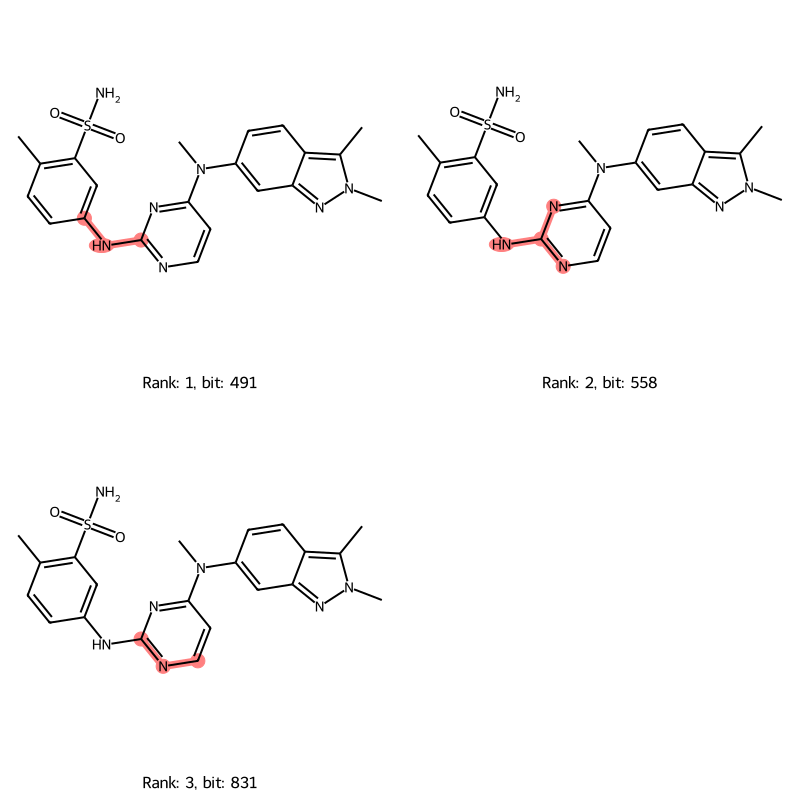

In [47]:
draw120 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=120,
                          rank=3,
                          fp_size=1024)
draw120

Rank: 1
Attention score: 0.04220
bit: 452
bit_info: ((17, 1),)
SMILES: cC(C)=O
Rank: 2
Attention score: 0.04012
bit: 723
bit_info: ((15, 1), (11, 1), (16, 1))
SMILES: cc(c)C
Rank: 3
Attention score: 0.03827
bit: 342
bit_info: ((41, 3),)
SMILES: CC(C)[C@H](O)[C@@H](C)[C@@H](O)[C@H](C)C


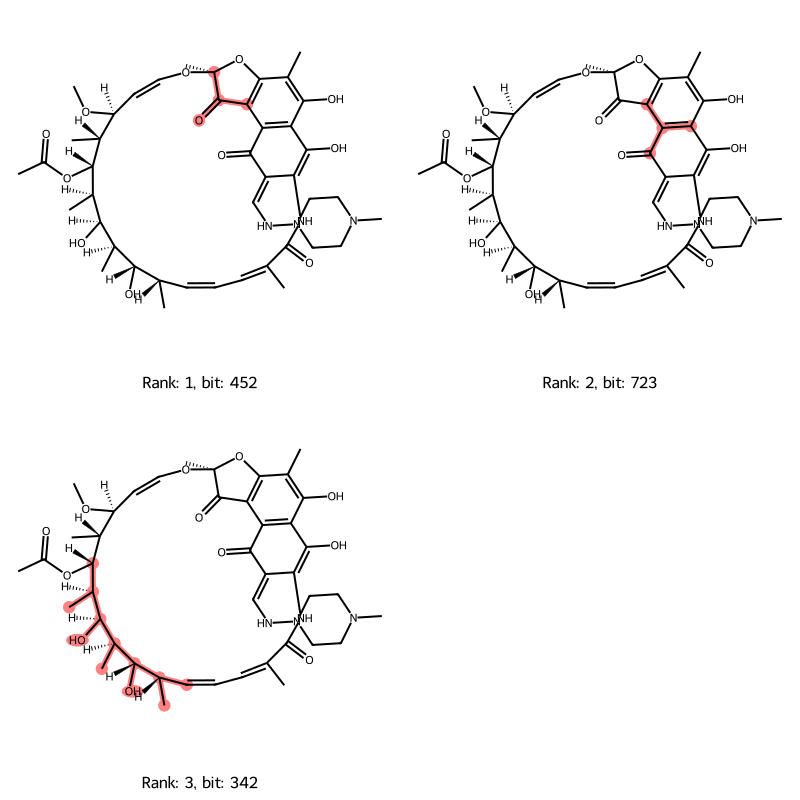

In [48]:
draw26 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=26,
                          rank=3,
                          fp_size=1024)
draw26

Rank: 1
Attention score: 0.04811
bit: 99
bit_info: ((8, 2),)
SMILES: cn(-c)cnn
Rank: 2
Attention score: 0.04632
bit: 390
bit_info: ((4, 2),)
SMILES: cnn(c(n)=O)C(C)C
Rank: 3
Attention score: 0.02930
bit: 314
bit_info: ((6, 1),)
SMILES: c=O


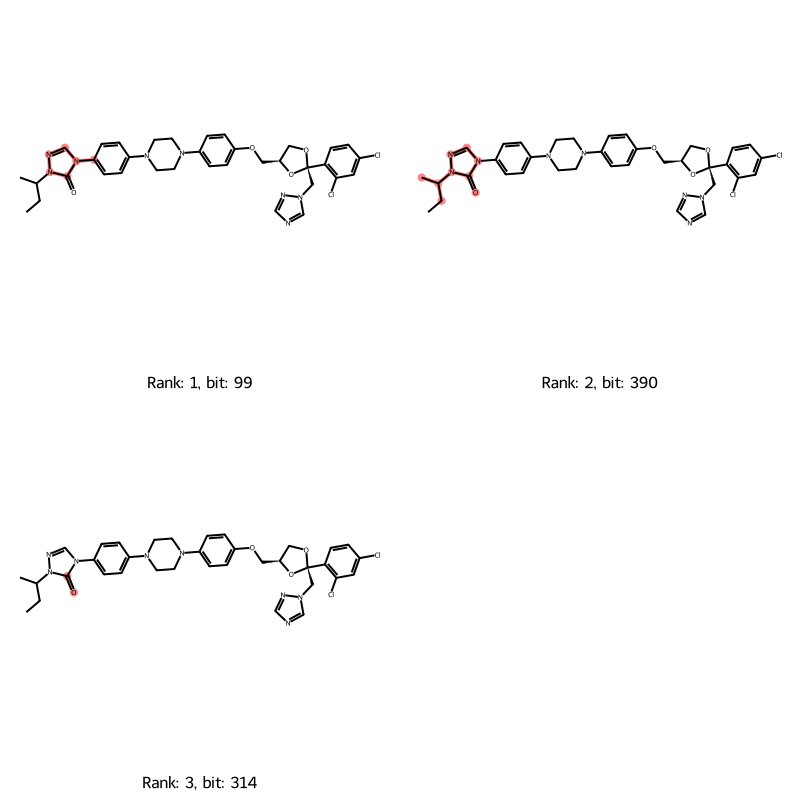

In [49]:
draw81 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=81,
                          rank=3,
                          fp_size=1024)
draw81

Rank: 1
Attention score: 0.05203
bit: 491
bit_info: ((24, 1),)
SMILES: cNc
Rank: 2
Attention score: 0.04003
bit: 747
bit_info: ((16, 2),)
SMILES: cc(c)CN(C)C
Rank: 3
Attention score: 0.03143
bit: 558
bit_info: ((25, 1),)
SMILES: nc(n)N


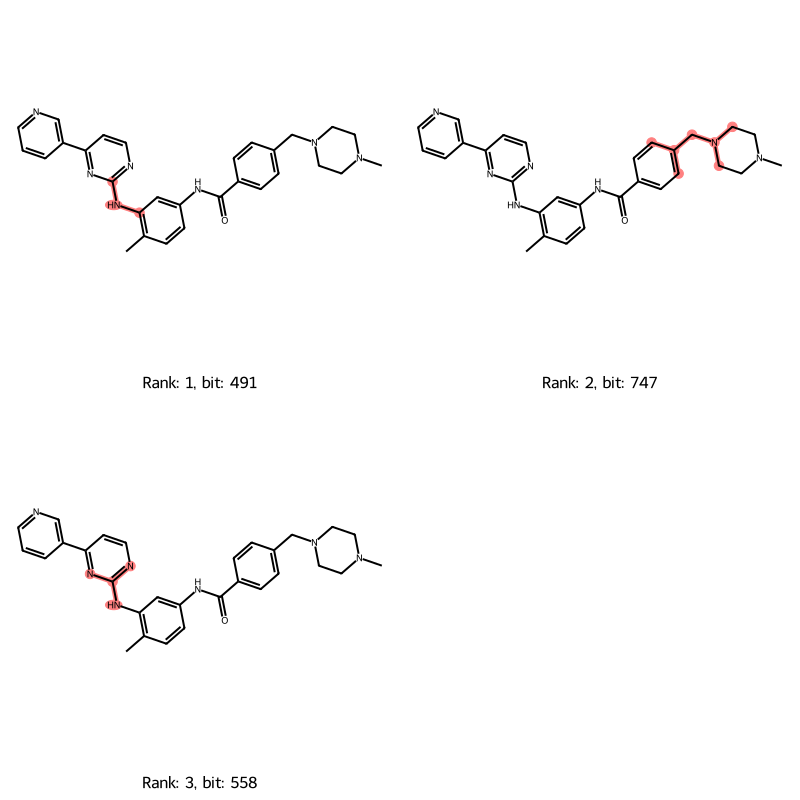

In [50]:
draw77 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=77,
                          rank=3,
                          fp_size=1024)
draw77

Rank: 1
Attention score: 0.04066
bit: 831
bit_info: ((51, 1),)
SMILES: cnc
Rank: 2
Attention score: 0.03762
bit: 896
bit_info: ((7, 3), (73, 3))
SMILES: CCN(C(=O)C(NC)C(C)C)C(C)C
Rank: 3
Attention score: 0.01945
bit: 989
bit_info: ((45, 3),)
SMILES: coc1c(C)c(=O)c(N)cc-1n


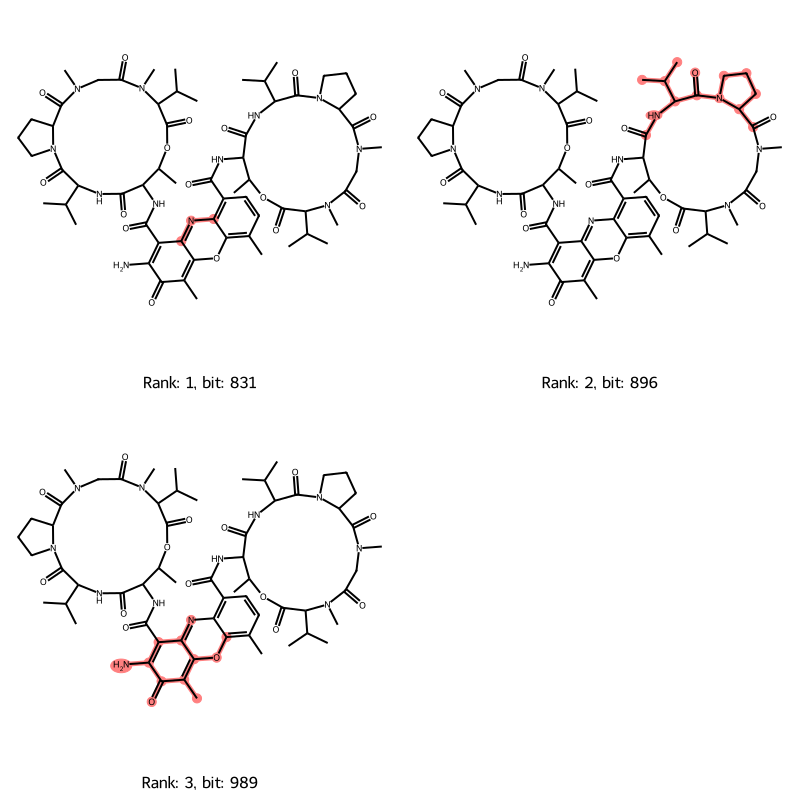

In [51]:
draw48 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=48,
                          rank=3,
                          fp_size=1024)
draw48

Rank: 1
Attention score: 0.03314
bit: 140
bit_info: ((30, 1),)
SMILES: cnn
Rank: 2
Attention score: 0.03178
bit: 896
bit_info: ((16, 2), (18, 2))
SMILES: cccc(c)-c
Rank: 3
Attention score: 0.01564
bit: 922
bit_info: ((29, 1),)
SMILES: [nH]nn


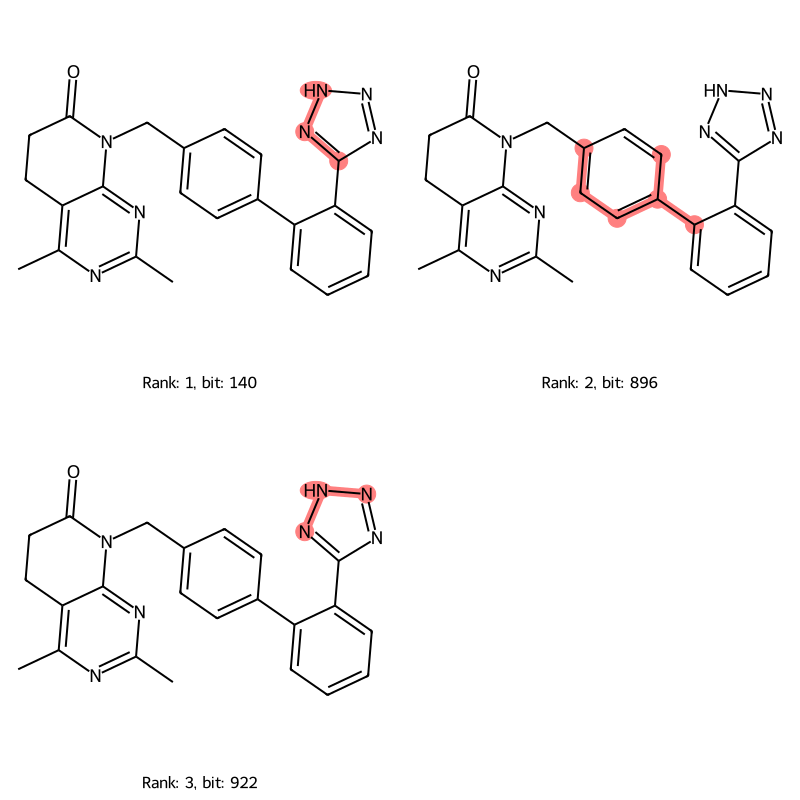

In [52]:
draw174 = AttentionAnalysis(mols=mols,
                          attention_score=attention_score,
                          dataframe=test_df,
                          bit_info_list=bit_info_list,
                          index=174,
                          rank=3,
                          fp_size=1024)
draw174